In [5]:
#ライブラリのインポート
import csv
import os
import numpy as np
import pandas as pd
import glob
import xlsxwriter

from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

In [8]:
#########################書き換え必要！#########################
#作業用ディレクトリの設定
os.chdir("C:\\Users\\MotionData\\sub1")
#ファイルの指定
file = "./20210426_sub1_"
#運動周波数の指定
speed = 1.75
#peak抽出の間隔設定
peakorder = 50
#########################書き換え必要！#########################

#input
rowfile = glob.glob( f'{file}*.csv')

#output
sortfile = f'{file}sort.csv'
peakfile = f'{file}peak.xlsx'
AEfile = f'{file}AE.xlsx'
rhythmfile = f'{file}rhythm_error.xlsx'

#sortファイルの列名
columns_name_sort = ["Time","pre1_h","pre1_f","pre2_h","pre2_f","pre3_h","pre3_f","0min_h","0min_f","5min_h","5min_f","10min_h","10min_f","20min_h","20min_f","30min_h","30min_f","40min_h","40min_f","50min_h","50min_f","60min_h","60min_f","90min_h","90min_f"]

#peakfileの列名
columns_name_peak = ["pre1_h","pre1_f","pre2_h","pre2_f","pre3_h","pre3_f","0min_h","0min_f","5min_h","5min_f","10min_h","10min_f","20min_h","20min_f","30min_h","30min_f","40min_h","40min_f","50min_h","50min_f","60min_h","60min_f","90min_h","90min_f"]

#グラフ・AEファイルの列名
graph_name = ["pre1", "pre2", "pre3", "0min", "5min", "10min", "20min", "30min", "40min", "50min", "60min", "90min"]

#空のデータフレーム作成（sortファイル用）
df_sort = pd.DataFrame(columns=columns_name_sort)
#空のデータフレームに"Time"列を追加
 ##240Hzのサンプリングレート、40秒まで
time = [(i*(1/240)) for i in range(0,9600)]
df_sort["Time"] = time

■角度センサのローデータを時系列順に並び替え

In [9]:
#datasort
for i in range(len(rowfile)):
    data = pd.read_csv(rowfile[i], names=('SensNo','X', 'Y', 'Z', 'Rx', 'Ry', 'Rz','none'))
    data_s = data.sort_values("SensNo")
    data_01 = data_s[(data_s['SensNo'] == 1)]
    data_01_s = data_01.sort_index(ascending=True)
    angle_h = list(data_01_s["Rz"])
    data_02 = data_s[(data_s['SensNo'] == 2)]
    data_02_s = data_02.sort_index(ascending=True)
    angle_f = list(data_02_s["Rz"])
    df_sort[columns_name_sort[i*2+1]] = pd.Series(angle_h)
    df_sort[columns_name_sort[i*2+2]] = pd.Series(angle_f)

#Excelに書き出し
df_sort.to_csv(sortfile)

■ピーク分析、ピーク値ファイル生成

In [10]:
#peakanalisys
#peak listの作成
sortdata = pd.read_csv(sortfile)

x = sortdata.iloc[:,1]
x = x.values

peaklist = list()

with np.errstate(invalid='ignore'):
    for i in range(2,len(columns_name_peak)+2):
        y = sortdata.iloc[:,i]
        y = y.values
        maxid = signal.argrelmin(y,order=peakorder)
        peaktiming = x[maxid]
        peaktiming = list(peaktiming)
        peaklist.append(peaktiming)

#データフレームに変換

    peaklist_df = pd.DataFrame(peaklist)
    peaklist_df = peaklist_df.T
    peaklist_df.columns= columns_name_peak

#Excelに書き出し
    peaklist_df.to_excel(peakfile)


■トライアルごとのグラフ描画

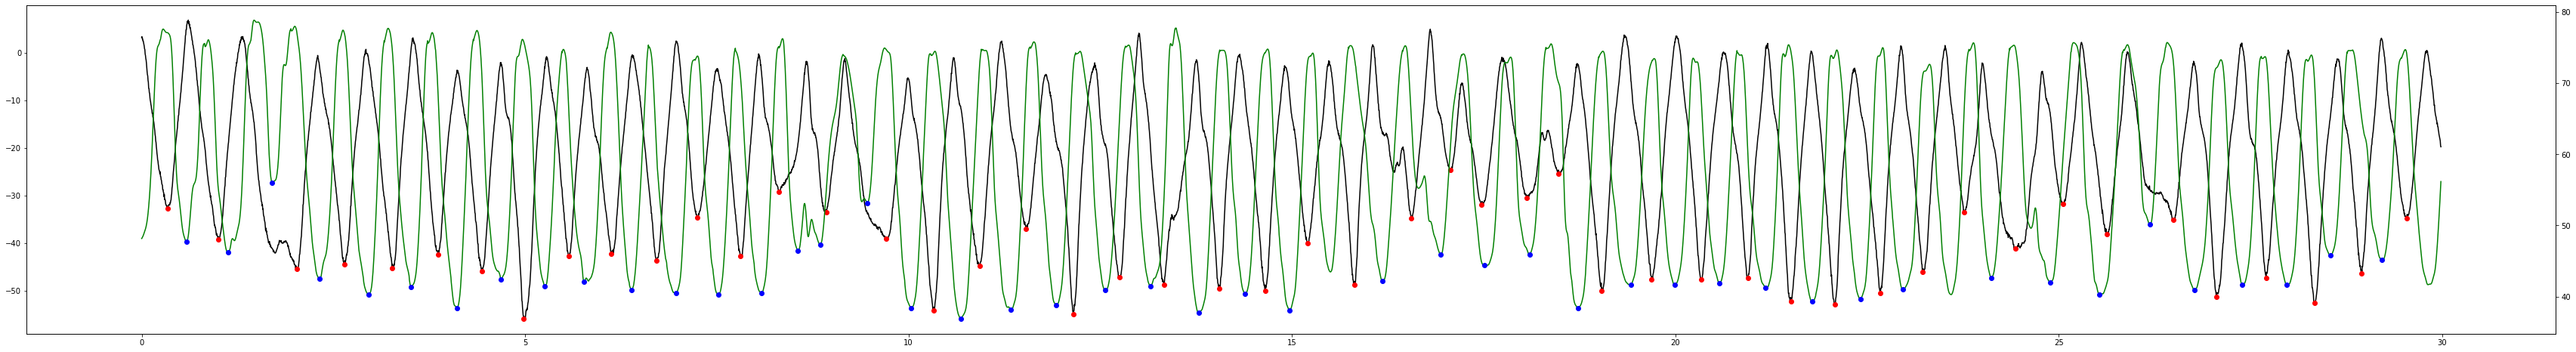

In [11]:
#グラフの描画

with np.errstate(invalid='ignore'):
    for i in range (1,len(graph_name)+1):
        fig, ax = plt.subplots(1,1,figsize=(60,8), sharex=True)
        
        #hand
        ax.plot(x,sortdata.iloc[:,i*2].values,'k-')
        ax.plot(x[signal.argrelmin(sortdata.iloc[:,i*2].values,order=peakorder)],sortdata.iloc[:,i*2].values[signal.argrelmin(sortdata.iloc[:,i*2].values,order=peakorder)],'ro',label='hand')
        
        #foot
        ax01 = ax.twinx()
        ax01.plot(x,sortdata.iloc[:,i*2+1],'g-')
        ax01.plot(x[signal.argrelmin(sortdata.iloc[:,i*2+1].values,order=peakorder)],sortdata.iloc[:,i*2+1].values[signal.argrelmin(sortdata.iloc[:,i*2+1].values,order=peakorder)],'bo',label='foot')

        plt.show()
        plt.savefig(f"{graph_name[i-1]}.png")
        plt.close()

■手足の相対位相（relative phase）のエラー値を算出、ファイル生成

In [12]:
#relative phaseのエラー値の計算

df_AE = pd.DataFrame(columns=graph_name)
peakdata = pd.read_excel(peakfile)

for i in range(0,len(graph_name)):
    AElist = list()
    hand = peakdata.iloc[:,i*2+1]
    foot = peakdata.iloc[:,i*2+2] 
    for f in range(len(foot)):
        for h in range(len(hand)-1):
            if (foot[f] >= hand[h]) & (foot[f] < hand[h+1]): 
                relative_phase = 360*((foot[f] - hand[h]) / (hand[h+1] - hand[h]))
                AE_rf = abs(relative_phase - 180)
                AElist.append(AE_rf)
                break
            else:
                continue
    df_AE[graph_name[i]] = pd.Series(AElist)
            

#Excelに書き出し
df_AE.to_excel(AEfile)

■周期の計算

In [13]:
df_rhythm = pd.DataFrame(columns=columns_name_peak)
peakdata = pd.read_excel(peakfile)

for i in range(1,len(columns_name_peak)+1):
    rhythmlist = list()
    peak = peakdata.iloc[:,i] 
    for j in range(len(peak)-1):
        rhythm = abs(speed - 1/(peak[j+1] - peak[j]))
        rhythmlist.append(rhythm)
    
    df_rhythm[columns_name_peak[i-1]] = pd.Series(rhythmlist)
    

df_rhythm.to_excel(rhythmfile)